In [6]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

import re
import networkx as nx

from IPython.display import Image
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [91]:
articles = pd.read_csv('articles.csv')
authors=pd.read_csv('authors.csv')
authorship=pd.read_csv('authorship.csv')

In [3]:
articles.head(2)

,id,doi
0,0,10.1103/PhysRev.1.16
1,1,10.1103/PhysRev.1.2


In [4]:
authors.head(2)

,id,given,middle,surname,name
0,60257,B.,E.,O’Rourke,B E O’Rourke
1,66812,M.,NaN,Rosenberg,M Rosenberg


In [5]:
authorship.head(2)

,article,author
0,0,0
1,1,1


In [237]:
productivity = authorship.groupby('author')['article'].count().to_dict()

In [238]:
prod, count = np.unique(sorted(list(productivity.values())), return_counts=True)

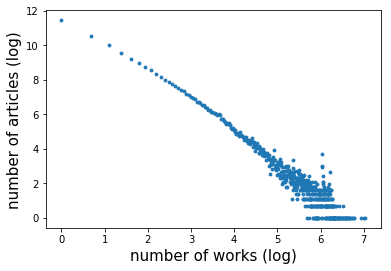

In [241]:
plt.scatter(np.log(prod), np.log(count),s=8)
plt.xlabel('number of works (log)',size=15)
plt.ylabel('number of articles (log)',size=15)

In [53]:
auth_high_prod = [authors[authors.id == i]['name'] for i in productivity.keys() if productivity[i] >= 700]
auth_high_prod

[51481    J  Lee
 Name: name, dtype: object, 241571    Y  Wang
 Name: name, dtype: object, 231273    T  Suzuki
 Name: name, dtype: object, 3684    J  Wang
 Name: name, dtype: object, 233046    Y  Chen
 Name: name, dtype: object, 243287    H  Kim
 Name: name, dtype: object, 57424    Y  Liu
 Name: name, dtype: object, 20020    S  Lee
 Name: name, dtype: object, 235042    C  Chen
 Name: name, dtype: object, 223167    S  Banerjee
 Name: name, dtype: object, 113622    S  Chen
 Name: name, dtype: object, 195608    L  Zhang
 Name: name, dtype: object, 134452    X  Li
 Name: name, dtype: object, 85091    Y  Zhang
 Name: name, dtype: object, 163084    J  Li
 Name: name, dtype: object, 98649    J  Zhang
 Name: name, dtype: object, 58951    H  Kagan
 Name: name, dtype: object, 239652    M S Alam
 Name: name, dtype: object, 60307    R  Kass
 Name: name, dtype: object, 49179    D N Brown
 Name: name, dtype: object]

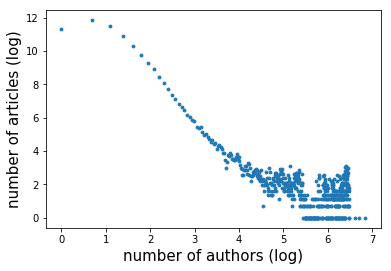

In [235]:
writers = authorship.groupby('article')['author'].count().to_dict()
writing, c = np.unique(sorted(list(writers.values())), return_counts=True)
plt.scatter(np.log(writing), np.log(c),s=8)
plt.xlabel('number of authors (log)',size=15)
plt.ylabel('number of articles (log)',size=15)

In [8]:
citcit = pd.read_csv('citing_cited.csv')

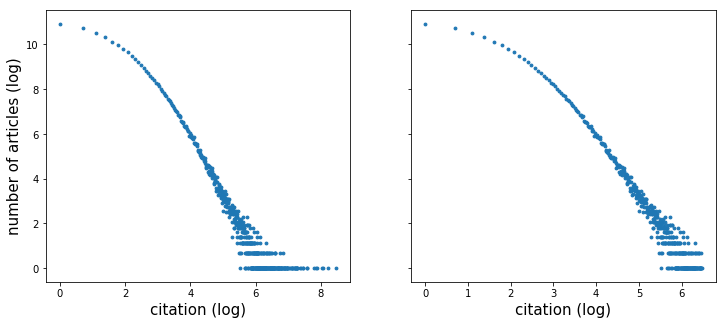

In [234]:
cit_rel = citcit.groupby('cited_doi')['citing_doi'].count().to_dict()
citation, c =np.unique(sorted(list(cit_rel.values())),return_counts=True)
fig,axis=plt.subplots(1,2,figsize=(12,5),sharey=True)
axis[0].scatter(np.log(citation), np.log(c),s=8)
axis[0].set_xlabel('citation (log)',size=15)
axis[0].set_ylabel('number of articles (log)',size=15)

axis[1].scatter(np.log(citation[:500]), np.log(c[:500]),s=8)
axis[1].set_xlabel('citation (log)',size=15)

In [58]:
paper_high_citation = [(i, cit_rel[i])  for i in cit_rel.keys() if cit_rel[i] >= 2000]
paper_high_citation

[('10.1103/PhysRevLett.77.3865', 3088),
 ('10.1103/PhysRev.136.B864', 3712),
 ('10.1103/PhysRevLett.45.566', 2651),
 ('10.1103/PhysRevB.13.5188', 2569),
 ('10.1103/PhysRevB.23.5048', 3191),
 ('10.1103/PhysRevB.54.11169', 2387),
 ('10.1103/PhysRev.140.A1133', 4763)]

In [66]:
citnet = nx.DiGraph()
dois = set(citcit['citing_doi']).union(set(citcit['cited_doi']))
for doi in dois:
    c = 0
    if doi in cit_rel:
        c = cit_rel[doi]
    citnet.add_node(doi, cit=c)

num_entries = citcit.shape[0]
for i in range(num_entries):
    entry = citcit.iloc[i]
    citnet.add_edge(entry['citing_doi'], entry['cited_doi'])
nx.write_gpickle(citnet, 'citnet.net')

In [70]:
citnet.in_degree('10.1103/PhysRevLett.77.3865'), citnet.in_degree('10.1103/PhysRev.136.B864')

(3083, 3710)

In [242]:
citnet = nx.read_gpickle('citnet.net')
len(citnet.nodes()), len(citnet.edges())

(450084, 4692056)

In [45]:
def credallocation(title, allocation, nobel):
    h = len(allocation) / 2
    fig, ax = plt.subplots(figsize=(10, h))
    authors = list(allocation.keys())
    y_pos = np.arange(len(authors))
    credits = list(allocation.values())

    colors = ['b'] * len(authors)
    colors[nobel] = 'r'
    ax.barh(y_pos, credits,align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(authors, size=15)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(title, size=15)
    maxx = max(credits) * (1 + 0.05)
    for i, v in enumerate(credits):
        ax.text(maxx, i + .25, '{0:.3f}'.format(v), color='b', fontweight='bold')

### Credit Allocation 

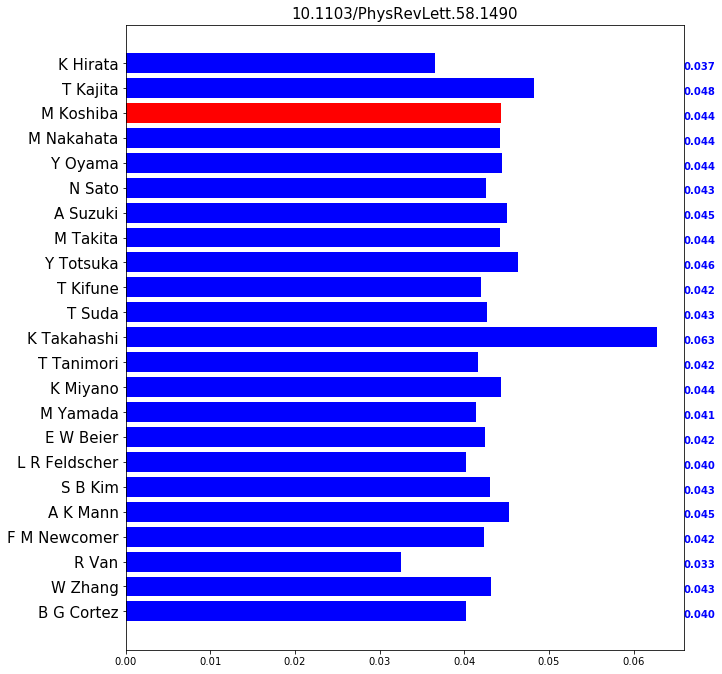

In [90]:
title = '10.1103/PhysRevLett.58.1490'
allo = pd.read_clipboard(header=None,sep=',')
entries = []
for i in range(allo.shape[0]):
    entry = allo.iloc[i]
    entries.append((entry[0], entry[1]))
allocation=OrderedDict(entries)

credallocation(title, allocation, 2)

### NetworkX to Pajek

In [3]:
nx.write_pajek(citnet, 'cit.net')

### Compute the PageRank of nodes, the scores will be used as the importances of papers

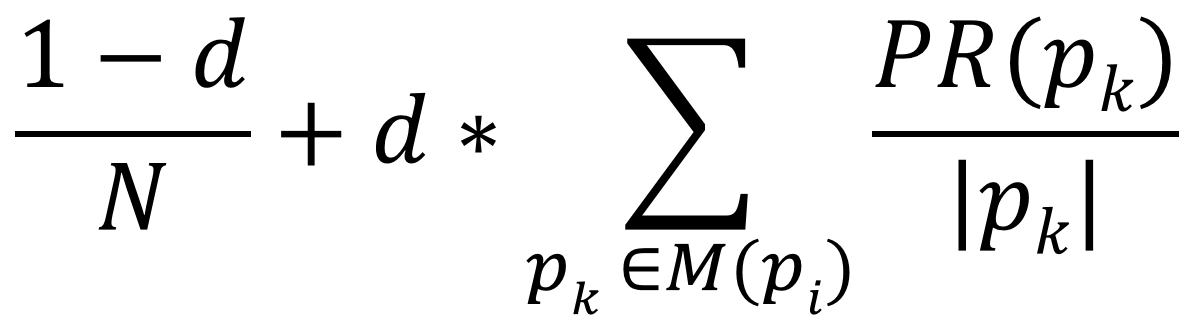

In [83]:
Image('https://data-artisans.com/img/blog/formula.png')

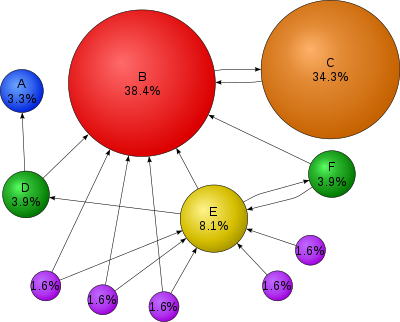

In [84]:
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/PageRanks-Example.svg/400px-PageRanks-Example.svg.png')

In [70]:
pr = pd.read_csv('pagerank.csv')

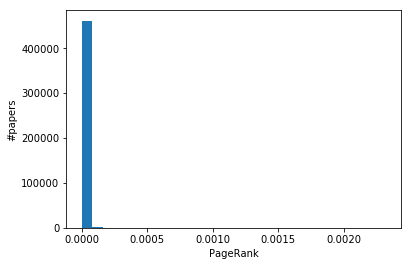

In [25]:
nbins = 30
minpr, maxpr = min(pr.pr), max(pr.pr)
width = (maxpr - minpr) / nbins
bins = [minpr + width * _ for _ in range(nbins)]
plt.hist(pr.pr, bins)
plt.xlabel('PageRank')
plt.ylabel('#papers')

In [21]:
pr.pr.describe()

count    4.621440e+05
mean     2.163828e-06
std      1.103079e-05
min      4.357640e-07
25%      4.791520e-07
50%      6.572245e-07
75%      1.264224e-06
max      2.403280e-03
Name: pr, dtype: float64

In [27]:
citnet = pd.read_csv('citnet.csv', names=['S', 'T'])

In [45]:
citations = pd.read_csv('indegrees.txt', names=['id','ncit'])

In [59]:
awardings = pd.read_csv('nobel.csv')

In [71]:
for i, row in awardings.iterrows():
    ind = int(articles[articles.doi == row.article].id)
    ncit = int(citations[citations.id == ind].ncit)
    p = float(pr[pr.i == ind].pr)
    awardings.set_value(i, 'id', ind)
    awardings.set_value(i, 'ncit', ncit)
    awardings.set_value(i, 'pr', p)

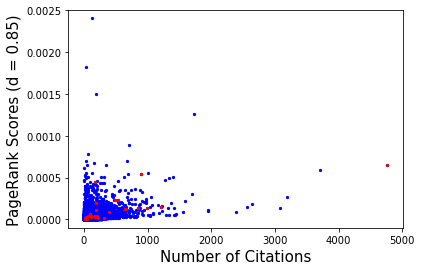

In [73]:
plt.scatter(citations.ncit, pr.pr, s=5, c='b')
plt.scatter(awardings.ncit, awardings.pr,s=5,c='r')
plt.ylim((-0.0001, 0.0025))
plt.xlabel('Number of Citations', size=15)
plt.ylabel('PageRank Scores (d = 0.85)', size=15)

## Most Cited Nobel-prize winning paper in APS (4757)
Self-Consistent Equations Including Exchange and Correlation Effects, 
W. Kohn and L. J. Sham, Phys. Rev. 140, A1133 – Published 15 November 1965

In [87]:
authorship.head(2)

,article,author
0,0,0
1,1,1


In [88]:
awardings.head(2)

,year,pub_year,article,id,ncit,pr
0,2013,1964,10.1103/PhysRevLett.13.508,363616.0,187.0,0.000115
1,2013,1964,10.1103/PhysRevLett.13.321,363841.0,187.0,0.000193


In [89]:
winners = ['S Haroche','D J Wineland','K S Novoselov','A K Geim','A Fert','P W Higgs','F Englert','S Perlmutter','A G Riess','B P Schmidt','K C Kao','W S Boyle','G E Smith','Y Nambu','M Kobayashi','T Maskawa','P Grunberg','J C Mather','G Smoot','R J Glauber','J L Hall','T W Hänsch','T Hänsch','D J Gross','F Wilczek','H D Politzer','A A Abrikosov','A J Leggett','R Davis','M Koshiba','R Giacconi','E A Cornell','C E Wieman','W Ketterle','J S Kilby','H Kroemer','Z I Alferov','M Veltman','G ’t Hooft','R B Laughlin','D C Tsui','H L Stormer','S Chu','C Cohen-Tannoudji','W D Phillips','D D Osheroff','D M Lee','R C Richardson','F Reines','M L Perl']

In [92]:
labels = []
for w in winners:
    auth = authors[authors.name == w]
    if auth.shape[0]:
        labels.append(int(auth.id))
    else:
        print(w)

A G Riess
B P Schmidt
J S Kilby
G ’t Hooft


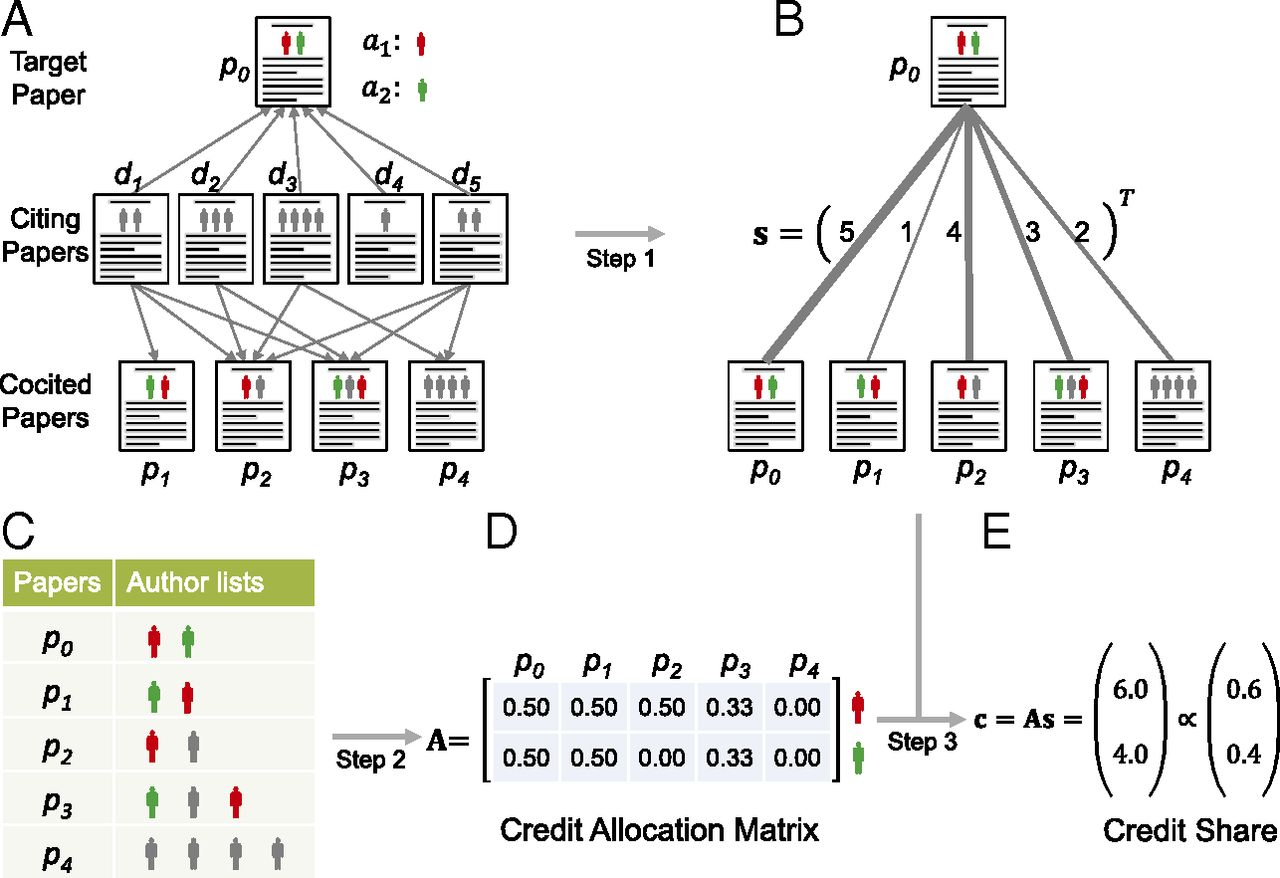

In [93]:
Image('http://www.pnas.org/content/pnas/111/34/12325/F2.large.jpg')

In [99]:
hooft = authors[authors.name.str.contains('Hooft')]

In [103]:
hooftworks = authorship[authorship.author.isin(hooft.id)].article

In [104]:
hooftworks

153382      72257
183749      81892
188943      83537
212578      90906
292317     119905
307458     125368
325545     131037
337935     135086
943453     271246
948548     273252
1616708    376283
1617930    376605
1735164    400845
1871853    416759
1975460    427248
2142434    439854
2170302    441458
2189172    442655
2287310    448473
2374343    453146
2470550    461779
2470723    461863
Name: article, dtype: int64

In [105]:
articles[articles.id.isin(hooftworks)]

,id,doi,journal,numauth
72257,72257,10.1103/PhysRevA.50.R14,PRA,7
81892,81892,10.1103/PhysRevA.63.063809,PRA,3
83537,83537,10.1103/PhysRevA.65.053821,PRA,4
90906,90906,10.1103/PhysRevA.73.032339,PRA,7
119905,119905,10.1103/PhysRevB.31.8041,PRB,2
125368,125368,10.1103/PhysRevB.35.8281,PRB,4
131037,131037,10.1103/PhysRevB.38.4314,PRB,6
135086,135086,10.1103/PhysRevB.40.1825,PRB,8
271246,271246,10.1103/PhysRevD.14.3432,PRD,1
273252,273252,10.1103/PhysRevD.18.2199.3,PRD,1


In [108]:
from habanero import Crossref

In [109]:
cr = Crossref()

In [154]:
cr.works(ids='10.1002/ana.1256')

{'message': {'DOI': '10.1002/ana.1256',
  'ISSN': ['0364-5134', '1531-8249'],
  'URL': 'http://dx.doi.org/10.1002/ana.1256',
  'author': [{'affiliation': [], 'family': 'Nguyen', 'given': 'Minh Dang'},
   {'affiliation': [], 'family': 'Julien', 'given': 'Jean-Pierre'},
   {'affiliation': [], 'family': 'Rivest', 'given': 'Serge'}],
  'container-title': ['Annals of Neurology'],
  'content-domain': {'crossmark-restriction': False, 'domain': []},
  'created': {'date-parts': [[2002, 8, 25]],
   'date-time': '2002-08-25T04:51:41Z',
   'timestamp': 1030251101000},
  'deposited': {'date-parts': [[2017, 7, 21]],
   'date-time': '2017-07-21T19:50:02Z',
   'timestamp': 1500666602000},
  'indexed': {'date-parts': [[2018, 4, 4]],
   'date-time': '2018-04-04T20:50:25Z',
   'timestamp': 1522875025170},
  'is-referenced-by-count': 69,
  'issn-type': [{'type': 'print', 'value': '0364-5134'},
   {'type': 'electronic', 'value': '1531-8249'}],
  'issue': '5',
  'issued': {'date-parts': [[2001]]},
  'licens

In [152]:
f='/Volumes/Files/Data/crossref-works.2018-01-21.json'
with open(f) as file:
    for _ in range(10):
        next(file)
        
    line = json.loads(file.readline())

In [206]:
alloc_cit = pd.read_csv('alloc_cite.csv')
alloc_pr = pd.read_csv('alloc_pr.csv')
alloc = pd.read_csv('alloc.csv')

In [208]:
from functools import reduce
allocs = [alloc_cit, alloc_pr, alloc]
credits = reduce(lambda left,right: pd.merge(left,right), allocs)

In [184]:
uid = np.unique(credits.id)

In [185]:
credits[credits.id == uid[0]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
20,7439,10.1103/PhysRev.122.345,Y Nambu,0.569669,0.610877,0.537713,1
21,7439,10.1103/PhysRev.122.345,G Jona-Lasinio,0.430331,0.389123,0.462287,0


In [186]:
credits[credits.id == uid[1]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
97,15154,10.1103/PhysRev.140.A1133,W Kohn,0.57356,0.583473,0.61459,0
98,15154,10.1103/PhysRev.140.A1133,L J Sham,0.42644,0.416527,0.38541,0


In [189]:
credits[credits.id == uid[4]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
1,363841,10.1103/PhysRevLett.13.321,F Englert,0.500768,0.5006,0.50265,1
2,363841,10.1103/PhysRevLett.13.321,R Brout,0.499232,0.4994,0.49735,0


In [190]:
credits[credits.id == uid[5]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
57,367203,10.1103/PhysRevLett.20.1205,R Davis,0.461038,0.516027,0.445749,1
58,367203,10.1103/PhysRevLett.20.1205,D S Harmer,0.276508,0.247225,0.278876,0
59,367203,10.1103/PhysRevLett.20.1205,K C Hoffman,0.262454,0.236748,0.275375,0


In [191]:
credits[credits.id == uid[6]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
116,371629,10.1103/PhysRevLett.28.885,D D Osheroff,0.395737,0.375204,0.367027,1
117,371629,10.1103/PhysRevLett.28.885,R C Richardson,0.320761,0.326095,0.324219,1
118,371629,10.1103/PhysRevLett.28.885,D M Lee,0.283502,0.298701,0.308754,1


In [193]:
credits[credits.id == uid[8]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
53,373261,10.1103/PhysRevLett.30.1343,D J Gross,0.549276,0.560693,0.537832,1
54,373261,10.1103/PhysRevLett.30.1343,F Wilczek,0.450724,0.439307,0.462168,1


In [202]:
credits[credits.id == uid[10]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
119,375790,10.1103/PhysRevLett.35.1489,M L Perl,0.048575,0.042955,0.039035,1
120,375790,10.1103/PhysRevLett.35.1489,G S Abrams,0.027794,0.029213,0.030817,0
121,375790,10.1103/PhysRevLett.35.1489,A M Boyarski,0.043956,0.039084,0.033302,0
122,375790,10.1103/PhysRevLett.35.1489,M Breidenbach,0.038827,0.035973,0.032835,0
123,375790,10.1103/PhysRevLett.35.1489,D D Briggs,0.011971,0.013998,0.016664,0
124,375790,10.1103/PhysRevLett.35.1489,F Bulos,0.029516,0.028795,0.028040,0
125,375790,10.1103/PhysRevLett.35.1489,W Chinowsky,0.025258,0.025919,0.027902,0
126,375790,10.1103/PhysRevLett.35.1489,J T Dakin,0.023947,0.022333,0.022633,0
127,375790,10.1103/PhysRevLett.35.1489,G J Feldman,0.044624,0.040159,0.037361,0
128,375790,10.1103/PhysRevLett.35.1489,C E Friedberg,0.025677,0.027426,0.030252,0


In [196]:
credits[credits.id == uid[11]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
94,383318,10.1103/PhysRevLett.48.1559,D C Tsui,0.390845,0.387741,0.382902,1
95,383318,10.1103/PhysRevLett.48.1559,H L Stormer,0.331002,0.311485,0.334361,1
96,383318,10.1103/PhysRevLett.48.1559,A C Gossard,0.278153,0.300774,0.282737,0


In [203]:
credits[credits.id == uid[13]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
16,386761,10.1103/PhysRevLett.53.1951,D Shechtman,0.247658,0.248879,0.247175,1
17,386761,10.1103/PhysRevLett.53.1951,I Blech,0.241187,0.243035,0.240197,0
18,386761,10.1103/PhysRevLett.53.1951,D Gratias,0.255504,0.253695,0.258596,0
19,386761,10.1103/PhysRevLett.53.1951,J W Cahn,0.255650,0.254392,0.254031,0


In [199]:
credits[credits.id == uid[14]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
100,388015,10.1103/PhysRevLett.55.48,S Chu,0.296537,0.198172,0.275788,1
101,388015,10.1103/PhysRevLett.55.48,L Hollberg,0.063483,0.075367,0.091973,0
102,388015,10.1103/PhysRevLett.55.48,J E Bjorkholm,0.124215,0.147229,0.141578,0
103,388015,10.1103/PhysRevLett.55.48,A Cable,0.128499,0.133790,0.149463,0
104,388015,10.1103/PhysRevLett.55.48,A Ashkin,0.387266,0.445442,0.341197,0


In [209]:
credits[credits.id == uid[15]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
31,390112,10.1103/PhysRevLett.57.2442,P Grünberg,0.293414,0.297781,0.268716,1
32,390112,10.1103/PhysRevLett.57.2442,R Schreiber,0.177675,0.176327,0.185236,0
33,390112,10.1103/PhysRevLett.57.2442,Y Pang,0.176020,0.174911,0.180658,0
34,390112,10.1103/PhysRevLett.57.2442,M B Brodsky,0.176872,0.176069,0.184732,0
35,390112,10.1103/PhysRevLett.57.2442,H Sowers,0.176020,0.174911,0.180658,0


In [205]:
credits[credits.id == uid[16]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
60,390863,10.1103/PhysRevLett.58.1490,K Hirata,0.034194,0.035065,0.036528,0
61,390863,10.1103/PhysRevLett.58.1490,T Kajita,0.048763,0.045945,0.048186,0
62,390863,10.1103/PhysRevLett.58.1490,M Koshiba,0.044780,0.044409,0.044304,1
63,390863,10.1103/PhysRevLett.58.1490,M Nakahata,0.044777,0.043715,0.044193,0
64,390863,10.1103/PhysRevLett.58.1490,Y Oyama,0.044966,0.044484,0.044500,0
65,390863,10.1103/PhysRevLett.58.1490,N Sato,0.042920,0.043280,0.042531,0
66,390863,10.1103/PhysRevLett.58.1490,A Suzuki,0.045210,0.044651,0.045040,0
67,390863,10.1103/PhysRevLett.58.1490,M Takita,0.044804,0.044389,0.044208,0
68,390863,10.1103/PhysRevLett.58.1490,Y Totsuka,0.045646,0.045092,0.046343,0
69,390863,10.1103/PhysRevLett.58.1490,T Kifune,0.041889,0.042810,0.042037,0


In [210]:
credits[credits.id == uid[17]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
110,393904,10.1103/PhysRevLett.61.169,P D Lett,0.159301,0.166630,0.167000,0
111,393904,10.1103/PhysRevLett.61.169,R N Watts,0.116381,0.147421,0.138758,0
112,393904,10.1103/PhysRevLett.61.169,C I Westbrook,0.117744,0.136010,0.150601,0
113,393904,10.1103/PhysRevLett.61.169,W D Phillips,0.252842,0.228671,0.232331,1
114,393904,10.1103/PhysRevLett.61.169,P L Gould,0.242973,0.197018,0.174427,0
115,393904,10.1103/PhysRevLett.61.169,H J Metcalf,0.110758,0.124250,0.136885,0


In [211]:
credits[credits.id == uid[18]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
22,393982,10.1103/PhysRevLett.61.2472,M N Baibich,0.083726,0.092099,0.093957,0
23,393982,10.1103/PhysRevLett.61.2472,J M Broto,0.083726,0.092118,0.094029,0
24,393982,10.1103/PhysRevLett.61.2472,A Fert,0.321913,0.256956,0.241482,1
25,393982,10.1103/PhysRevLett.61.2472,F N Van Dau,0.084302,0.092273,0.094040,0
26,393982,10.1103/PhysRevLett.61.2472,F Petroff,0.091432,0.098158,0.100665,0
27,393982,10.1103/PhysRevLett.61.2472,P Etienne,0.083726,0.092099,0.093957,0
28,393982,10.1103/PhysRevLett.61.2472,G Creuzet,0.083726,0.092099,0.093957,0
29,393982,10.1103/PhysRevLett.61.2472,A Friederich,0.083726,0.092099,0.093957,0
30,393982,10.1103/PhysRevLett.61.2472,J Chazelas,0.083726,0.092099,0.093957,0


In [212]:
credits[credits.id == uid[19]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
105,394302,10.1103/PhysRevLett.61.826,A Aspect,0.207707,0.210366,0.208113,0
106,394302,10.1103/PhysRevLett.61.826,E Arimondo,0.194870,0.200240,0.227436,0
107,394302,10.1103/PhysRevLett.61.826,R Kaiser,0.163106,0.167355,0.158208,0
108,394302,10.1103/PhysRevLett.61.826,N Vansteenkiste,0.163106,0.167355,0.158208,0
109,394302,10.1103/PhysRevLett.61.826,C Cohen-Tannoudji,0.271212,0.254684,0.248034,1


In [213]:
credits[credits.id == uid[20]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
87,409065,10.1103/PhysRevLett.75.3969,K B Davis,0.090711,0.098346,0.106988,0
88,409065,10.1103/PhysRevLett.75.3969,M - Mewes,0.081519,0.085788,0.100498,0
89,409065,10.1103/PhysRevLett.75.3969,M R Andrews,0.158051,0.158822,0.154229,0
90,409065,10.1103/PhysRevLett.75.3969,N J Van Druten,0.151857,0.153131,0.140923,0
91,409065,10.1103/PhysRevLett.75.3969,D S Durfee,0.135812,0.137822,0.139309,0
92,409065,10.1103/PhysRevLett.75.3969,D M Kurn,0.132692,0.135356,0.136163,0
93,409065,10.1103/PhysRevLett.75.3969,W Ketterle,0.249359,0.230735,0.221890,1


In [214]:
credits[credits.id == uid[21]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
11,409814,10.1103/PhysRevLett.76.1796,D M Meekhof,0.131006,0.135855,0.148627,0
12,409814,10.1103/PhysRevLett.76.1796,C Monroe,0.166828,0.171428,0.181892,0
13,409814,10.1103/PhysRevLett.76.1796,B E King,0.144949,0.148572,0.158032,0
14,409814,10.1103/PhysRevLett.76.1796,W M Itano,0.254300,0.249726,0.239237,0
15,409814,10.1103/PhysRevLett.76.1796,D J Wineland,0.302917,0.294418,0.272211,1


In [215]:
credits[credits.id == uid[22]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
3,411973,10.1103/PhysRevLett.77.4887,M Brune,0.209083,0.205269,0.208664,0
4,411973,10.1103/PhysRevLett.77.4887,E Hagley,0.086715,0.086542,0.080466,0
5,411973,10.1103/PhysRevLett.77.4887,J Dreyer,0.068876,0.072810,0.069863,0
6,411973,10.1103/PhysRevLett.77.4887,X Maître,0.074575,0.075852,0.073588,0
7,411973,10.1103/PhysRevLett.77.4887,A Maali,0.077771,0.080417,0.076557,0
8,411973,10.1103/PhysRevLett.77.4887,C Wunderlich,0.074714,0.076209,0.074390,0
9,411973,10.1103/PhysRevLett.77.4887,J M Raimond,0.198604,0.196584,0.205802,0
10,411973,10.1103/PhysRevLett.77.4887,S Haroche,0.209662,0.206317,0.210670,1


In [216]:
credits[credits.id == uid[23]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
46,421912,10.1103/PhysRevLett.84.3232,J Reichert,0.168426,0.162631,0.156875,0
47,421912,10.1103/PhysRevLett.84.3232,M Niering,0.073853,0.075147,0.084582,0
48,421912,10.1103/PhysRevLett.84.3232,R Holzwarth,0.152217,0.158519,0.162230,0
49,421912,10.1103/PhysRevLett.84.3232,M Weitz,0.147058,0.139580,0.129029,0
50,421912,10.1103/PhysRevLett.84.3232,T Udem,0.194606,0.194909,0.195966,0
51,421912,10.1103/PhysRevLett.84.3232,T W Hänsch,0.263841,0.269214,0.271319,1


In [217]:
credits[credits.id == uid[24]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
36,422458,10.1103/PhysRevLett.84.5102,S A Diddams,0.057685,0.058379,0.063334,0
37,422458,10.1103/PhysRevLett.84.5102,D J Jones,0.040547,0.042737,0.047251,0
38,422458,10.1103/PhysRevLett.84.5102,J Ye,0.116692,0.116485,0.141185,0
39,422458,10.1103/PhysRevLett.84.5102,S T Cundiff,0.055811,0.058904,0.070876,0
40,422458,10.1103/PhysRevLett.84.5102,J L Hall,0.095252,0.096633,0.108054,1
41,422458,10.1103/PhysRevLett.84.5102,J K Ranka,0.048375,0.049591,0.050794,0
42,422458,10.1103/PhysRevLett.84.5102,R S Windeler,0.053194,0.054053,0.054376,0
43,422458,10.1103/PhysRevLett.84.5102,R Holzwarth,0.148350,0.147294,0.131689,0
44,422458,10.1103/PhysRevLett.84.5102,T Udem,0.174404,0.170084,0.149284,0
45,422458,10.1103/PhysRevLett.84.5102,T W Hänsch,0.209690,0.205839,0.183158,1


In [218]:
credits[credits.id == uid[25]]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
83,431056,10.1103/PhysRevLett.9.439,R Giacconi,0.25,0.25,0.25,1
84,431056,10.1103/PhysRevLett.9.439,H Gursky,0.25,0.25,0.25,0
85,431056,10.1103/PhysRevLett.9.439,F R Paolini,0.25,0.25,0.25,0
86,431056,10.1103/PhysRevLett.9.439,B B Rossi,0.25,0.25,0.25,0


In [220]:
nobels = credits[credits.nobelwinner == 1]

In [222]:
sum(nobels.credit_cite >= nobels.credit_sb)

22

In [227]:
sum(nobels.credit_pr >= nobels.credit_sb)

21

In [225]:
sum(nobels.credit_pr < nobels.credit_sb)

9

In [228]:
nobels[nobels.credit_pr >= nobels.credit_sb]

,id,article,author,credit_cite,credit_pr,credit_sb,nobelwinner
0,363616,10.1103/PhysRevLett.13.508,P W Higgs,1.000000,1.000000,1.000000,1
15,409814,10.1103/PhysRevLett.76.1796,D J Wineland,0.302917,0.294418,0.272211,1
16,386761,10.1103/PhysRevLett.53.1951,D Shechtman,0.247658,0.248879,0.247175,1
20,7439,10.1103/PhysRev.122.345,Y Nambu,0.569669,0.610877,0.537713,1
24,393982,10.1103/PhysRevLett.61.2472,A Fert,0.321913,0.256956,0.241482,1
31,390112,10.1103/PhysRevLett.57.2442,P Grünberg,0.293414,0.297781,0.268716,1
45,422458,10.1103/PhysRevLett.84.5102,T W Hänsch,0.209690,0.205839,0.183158,1
52,362860,10.1103/PhysRevLett.10.84,R J Glauber,1.000000,1.000000,1.000000,1
53,373261,10.1103/PhysRevLett.30.1343,D J Gross,0.549276,0.560693,0.537832,1
55,373262,10.1103/PhysRevLett.30.1346,H D Politzer,1.000000,1.000000,1.000000,1


In [245]:
giant = max(nx.connected_component_subgraphs(citnet.to_undirected()), key=len)